# ![](https://img.shields.io/badge/vision-2f5ada) Train `MNIST`

# Imports

In [3]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet
!pip install tqdm --quiet
!pip install ml_collections --quiet

In [4]:
import requests
from io import BytesIO
import jax
import jax.numpy as jnp
import functools as ft
import optax  # for gradient optimization
import serket as sk
import matplotlib.pyplot as plt  # for plotting the predictions
from tqdm import tqdm  # for progress bar
from ml_collections import ConfigDict  # for configuration

config = ConfigDict()
config.EPOCHS = 1
config.LR = 1e-3
config.BATCH_SIZE = 128
config.seed = 0

## Data preparation

In [5]:
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
data = jnp.load(BytesIO(requests.get(url).content))

x_train = data["x_train"].reshape(-1, 1, 28, 28).astype("float32") / 255.0
x_train = jnp.array_split(x_train, x_train.shape[0] // config.BATCH_SIZE)
y_train = jnp.array_split(data["y_train"], len(data["y_train"]) // config.BATCH_SIZE)

x_test = data["x_test"].reshape(-1, 1, 28, 28).astype("float32") / 255.0
y_test = data["y_test"]

## Model creation

In [6]:
class ConvNet(sk.TreeClass):
    def __init__(self, key: jax.Array):
        k1, k2, k3 = jax.random.split(key, 3)
        self.conv1 = sk.nn.Conv2D(1, 32, 3, key=k1, padding="valid")
        self.pool1 = sk.nn.MaxPool2D(2, 2)
        self.conv2 = sk.nn.Conv2D(32, 64, 3, key=k2, padding="valid")
        self.pool2 = sk.nn.MaxPool2D(2, 2)
        self.linear = sk.nn.Linear(1600, 10, key=k3)

    def __call__(self, input: jax.Array) -> jax.Array:
        output = self.pool1(jax.nn.relu(self.conv1(input)))
        output = self.pool2(jax.nn.relu(self.conv2(output)))
        output = self.linear(jnp.ravel(output))
        return output

## Train

In [8]:
@jax.vmap
def softmax_cross_entropy(logits, onehot):
    assert onehot.shape == logits.shape == (10,)
    return -jnp.sum(jax.nn.log_softmax(logits) * onehot)


@jax.jit
@jax.vmap
def accuracy_func(logits, y):
    assert logits.shape == (10,)
    return jnp.argmax(logits) == y


def train(config: ConfigDict, x_train, y_train):
    # 1) create net and mask out all non-inexact parameters
    net = sk.tree_mask(ConvNet(key=jax.random.key(config.seed)))

    # visualize the network
    print(sk.tree_summary(net, depth=1))

    optim = optax.adam(config.LR)
    # 2) initialize the optimizer state
    optim_state = optim.init(net)

    def loss_func(net, x, y):
        # 3) vectorize the computation over the batch
        logits = jax.vmap(sk.tree_unmask(net))(x)
        onehot = jax.nn.one_hot(y, 10)
        # 4) use the appropriate loss function
        loss = jnp.mean(softmax_cross_entropy(logits, onehot))
        # return loss and logits as an auxillary output
        return loss, (loss, logits)

    @jax.jit
    def train_step(net, optim_state, x, y):
        # the loss function will have an output of (loss, logits)
        # as an auxillary output, and will have a gradient `grads` of same
        # structure as net with each array being the gradient of the
        # corresponding array in net
        grads, (loss, logits) = jax.grad(loss_func, has_aux=True)(net, x, y)

        # 5) update the parameters using the optimizer
        updates, optim_state = optim.update(grads, optim_state)
        net = optax.apply_updates(net, updates)
        return net, optim_state, (loss, logits)

    for i in (pbar := tqdm(range(1, config.EPOCHS + 1))):
        epoch_loss = []
        epoch_accuracy = []

        for j, (xb, yb) in enumerate(zip(x_train, y_train)):
            net, optim_state, (loss, logits) = train_step(net, optim_state, xb, yb)
            accuracy = jnp.mean(accuracy_func(logits, yb))

            desc = [f"Epoch: {i:003d}/{config.EPOCHS:003d}"]
            desc += [f"Batch: {j:003d}/{len(x_train):003d}"]
            desc += [f"loss: {loss:3e}\taccuracy: {accuracy:3f}"]
            pbar.set_description("\t".join(desc))

            epoch_loss.append(loss)
            epoch_accuracy.append(accuracy)

        desc = [f"Epoch: {i:003d}/{config.EPOCHS:003d}"]
        desc += [f"loss: {jnp.mean(jnp.stack(epoch_loss)):3e}"]
        desc += [f"accuracy: {jnp.mean(jnp.stack(epoch_accuracy)):3f}"]

        pbar.set_description("\t".join(desc))

    # return the unmasked network
    # (i.e. with all non-inexact parameters unmasked)
    return sk.tree_unmask(net)


net = train(config, x_train, y_train)

┌───────┬─────────┬──────┬────────┐
│Name   │Type     │Count │Size    │
├───────┼─────────┼──────┼────────┤
│.conv1 │Conv2D   │320   │1.25KB  │
├───────┼─────────┼──────┼────────┤
│.pool1 │MaxPool2D│      │        │
├───────┼─────────┼──────┼────────┤
│.conv2 │Conv2D   │18,496│72.25KB │
├───────┼─────────┼──────┼────────┤
│.pool2 │MaxPool2D│      │        │
├───────┼─────────┼──────┼────────┤
│.linear│Linear   │16,010│62.54KB │
├───────┼─────────┼──────┼────────┤
│Σ      │ConvNet  │34,826│136.04KB│
└───────┴─────────┴──────┴────────┘


Epoch: 001/001	loss: 2.879160e-01	accuracy: 0.920252: 100%|██████████| 1/1 [00:21<00:00, 21.87s/it]       


## Visualize

test accuracy: 0.9751999974250793


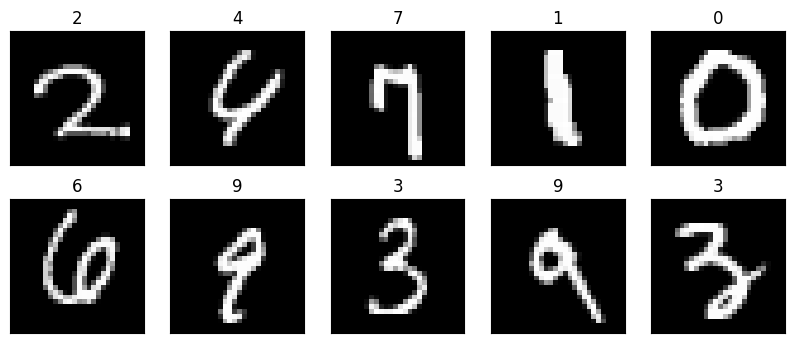

In [9]:
test_preds = jax.vmap(net)(x_test)
test_accuracy = jnp.mean(accuracy_func(test_preds, y_test))

print(f"test accuracy: {test_accuracy}")

# create 2x5 grid of images
key = jax.random.key(0)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
idxs = jax.random.randint(key, shape=(10,), minval=0, maxval=x_train[0].shape[0])

for i, idx in zip(axes.flatten(), idxs):
    # get the prediction
    pred = net(x_test[idx])
    # plot the image
    i.imshow(x_test[idx].reshape(28, 28), cmap="gray")
    # set the title to be the prediction
    i.set_title(jnp.argmax(pred))
    i.set_xticks([])
    i.set_yticks([])